#Importando los modulos necesarios

In [1]:
# Instalación de dependencias
!pip install qkeras keras-tuner

In [2]:
    import h5py
    import numpy as np
    import json
    import tensorflow as tf
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    from tensorflow.keras.layers import Input, MaxPooling2D, Flatten, Dropout, Add
    from tensorflow.keras.models import Model
    import matplotlib.pyplot as plt
    from qkeras import *
    import keras_tuner as kt

#Cargando el dataset de escalogramas

In [3]:


from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Tesis/Accelerometer_Dataset/accelerometer_BR_256NS_20Scales_cwt_dataset.h5'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def load_cwt_dataset(file_path='accelerometer_cwt_dataset.h5'):
    """
    Carga el dataset de escalogramas desde un archivo HDF5 y lo prepara para Keras.

    Args:
        file_path: Ruta al archivo HDF5

    Returns:
        dataset: Un diccionario con los datos y metadatos
    """


    with h5py.File(file_path, 'r') as hf:
        # Cargar escalogramas y etiquetas
        x_train = np.array(hf['train']['scalograms'])
        y_train = np.array(hf['train']['labels'])
        x_test = np.array(hf['test']['scalograms'])
        y_test = np.array(hf['test']['labels'])

        # Cargar metadatos
        num_classes = hf['metadata']['num_classes'][()]
        shape = tuple(hf['metadata']['shape'][()])

        # Cargar diccionario de etiquetas
        label_codes_dict = json.loads(hf['metadata'].attrs['label_codes_dict'])

    # Organizar datos como un dataset tipo Keras
    dataset = {
        'train': (x_train, y_train),
        'test': (x_test, y_test),
        'num_classes': num_classes,
        'input_shape': shape,
        'label_codes_dict': label_codes_dict
    }

    print(f"Dataset cargado: {x_train.shape[0]} muestras de entrenamiento, {x_test.shape[0]} muestras de prueba")
    print(f"Forma de cada escalograma: {shape}")
    print(f"Número de clases: {num_classes}")

    return dataset



In [5]:
# Carga el dataset
dataset = load_cwt_dataset(file_path)

# Obtén las partes del dataset
x_train, y_train = dataset['train']
x_test, y_test = dataset['test']
input_shape = dataset['input_shape']
num_classes = dataset['num_classes']

Dataset cargado: 96000 muestras de entrenamiento, 24000 muestras de prueba
Forma de cada escalograma: (20, 256)
Número de clases: 5


#Preparar las etiquetas con one-hot encoding

In [6]:
# Convertir etiquetas a formato one-hot
from tensorflow.keras.utils import to_categorical

# Verificar la forma actual de las etiquetas
print("Forma original de y_train:", y_train.shape)
print("Primeros 5 valores de y_train:", y_train[:5])

# Convertir etiquetas a formato one-hot
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Verificar la nueva forma
print("Nueva forma de y_train:", y_train.shape)
print("Primeros 5 valores de y_train:", y_train[:5])

Forma original de y_train: (96000,)
Primeros 5 valores de y_train: [4 0 4 2 2]
Nueva forma de y_train: (96000, 5)
Primeros 5 valores de y_train: [[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


#Verificando la normalización de los datos

Estado actual de los datos:
Valor máximo en x_train: 22.972864
Valor mínimo en x_train: 1.7875869e-10
Media de x_train: 0.18690377
Desviación estándar de x_train: 0.49832457


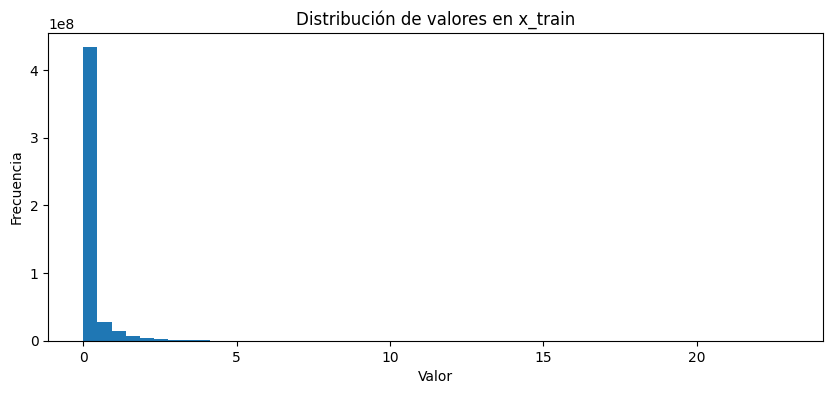

In [7]:
# Verificar si los datos ya están normalizados
print("Estado actual de los datos:")
print("Valor máximo en x_train:", np.max(x_train))
print("Valor mínimo en x_train:", np.min(x_train))
print("Media de x_train:", np.mean(x_train))
print("Desviación estándar de x_train:", np.std(x_train))

# Visualizar la distribución de valores
plt.figure(figsize=(10, 4))
plt.hist(x_train.flatten(), bins=50)
plt.title('Distribución de valores en x_train')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

#No estan normalizado, a normalizar!!

In [8]:
# Normalizar los datos de entrada usando el máximo de x_train para ambos conjuntos
max_value = np.max(x_train)  # Usar sólo el conjunto de entrenamiento para calcular el valor

# Convertir a float32 y normalizar
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value  # Usar el mismo valor para test

print("Después de normalizar:")
print("Valor máximo en x_train:", np.max(x_train))
print("Valor mínimo en x_train:", np.min(x_train))
print("Valor máximo en x_test:", np.max(x_test))
print("Valor mínimo en x_test:", np.min(x_test))

Después de normalizar:
Valor máximo en x_train: 1.0
Valor mínimo en x_train: 7.781297e-12
Valor máximo en x_test: 0.37690073
Valor mínimo en x_test: 1.8382905e-11


#Adaptando los datos para el modelo CNN

In [9]:
print("Forma de x_train:", x_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_test:", y_test.shape)
# Adaptar dimensiones para CNN (necesitamos un canal)
# Asumiendo que las dimensiones actuales son (n_samples, scales, time_steps)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

print("Forma final de x_train:", x_train.shape)
print("Forma final de x_test:", x_test.shape)

Forma de x_train: (96000, 20, 256)
Forma de y_train: (96000, 5)
Forma de x_test: (24000, 20, 256)
Forma de y_test: (24000, 5)
Forma final de x_train: (96000, 20, 256, 1)
Forma final de x_test: (24000, 20, 256, 1)


#Separamos una parte de los datos para la validacion del modelo

In [10]:
from sklearn.model_selection import train_test_split

# Dividir los datos
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train, y_train,
    test_size=0.2,  # 20% para validación
    random_state=42,  # Para reproducibilidad
    stratify=y_train  # Mantener la distribución de clases
)

# Verificar tamaños
print(f"Datos de entrenamiento: {x_train_final.shape[0]} muestras")
print(f"Datos de validación: {x_val.shape[0]} muestras")

Datos de entrenamiento: 76800 muestras
Datos de validación: 19200 muestras


# Definiendo los bloques convolucionales de mi modelo

In [11]:
def create_qconv_block(inputs, filters, kernel_size=3, strides=1,
                     use_residual=True, use_maxpool=False):
    """
    Bloque convolucional compatible con STM32
    """
    # Para capas intermedias, usar binary(alpha=1) para tipo s1
    x = QConv2D(filters=filters,
                kernel_size=kernel_size,
                strides=strides,
                padding='same',
                kernel_quantizer="binary(alpha=1)",
                bias_quantizer="binary(alpha=1)",
                use_bias=False)(inputs)

    # MaxPool antes de BatchNorm (como en el snippet)
    if use_maxpool:
        x = MaxPooling2D(pool_size=(2, 2))(x)

    x = QBatchNormalization()(x)
    x = QActivation("binary(alpha=1)")(x)

    # Conexión residual cuando sea posible
    if use_residual and strides == 1 and inputs.shape[-1] == filters:
        return Add()([inputs, x])

    return x

#Función NAS con Keras Tuner

In [12]:
def model_builder(hp):
    """
    Función de construcción de modelo para Keras Tuner
    Con cuantizaciones específicas compatibles con STM32
    """
    # Definir rangos de hiperparámetros
    conv_stages = hp.Int('conv_stages', min_value=2, max_value=4, step=1)
    initial_filters = hp.Choice('initial_filters', values=[32, 64])
    growth_rate = hp.Choice('growth_rate', values=[1.5, 2.0])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)

    # Opciones de cuantización compatibles con STM32
    # Solo exploramos s8, s1 y f32
    layer_precision = hp.Choice('layer_precision', values=[
        's1',  # Binario para capas internas
        's8',  # 8 bits con signo para mayor precisión
    ])

    # Mapeo de opciones de precisión a cuantizadores específicos
    quantizer_map = {
        's1': "binary(alpha=1)",
        's8': "quantized_bits(8,0,1)",
    }

    # Seleccionar cuantizadores basados en la precisión elegida
    hidden_kernel_quantizer = quantizer_map[layer_precision]
    hidden_activation = "binary(alpha=1)" if layer_precision == 's1' else "quantized_relu(8)"

    # Primera y última capa siempre con mayor precisión (s8)
    first_layer_quantizer = "quantized_bits(8,0,1)"
    last_layer_quantizer = "quantized_bits(8,0,1)"

    # Asegurar que el número de canales sea múltiplo de 32 (recomendado para STM32)
    def round_filters(filters):
        return 32 * max(1, round(filters / 32))

    # Input layer
    inputs = Input(shape=(x_train_final.shape[1], x_train_final.shape[2], 1))

    # Primera capa con mayor precisión (s8)
    x = QConv2D(filters=round_filters(initial_filters),
                kernel_size=3,
                padding='same',
                kernel_quantizer=first_layer_quantizer,
                bias_quantizer=first_layer_quantizer)(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = QBatchNormalization()(x)
    x = QActivation("quantized_relu(8)")(x)

    # Bloques intermedios con escalado progresivo
    filters = initial_filters

    for i in range(conv_stages):
        # Escalar progresivamente - más bloques en etapas posteriores
        num_blocks = 1 + i  # 1, 2, 3... bloques por etapa
        filters = round_filters(filters * growth_rate)

        for j in range(num_blocks):
            use_residual = j > 0 and layer_precision != 's1'  # Las capas binarias a veces no funcionan bien con residuales
            strides = 1
            use_maxpool = (j == num_blocks-1) and (i < conv_stages-1)

            # Definir el uso de bias según la cuantización
            use_bias = layer_precision != 's1'  # Capas binarias generalmente sin bias

            # Capa convolucional con cuantización seleccionada
            x_input = x
            x = QConv2D(filters=filters,
                     kernel_size=3,
                     strides=strides,
                     padding='same',
                     kernel_quantizer=hidden_kernel_quantizer,
                     bias_quantizer=hidden_kernel_quantizer if use_bias else None,
                     use_bias=use_bias)(x)

            # MaxPool antes de BatchNorm (recomendado para STM32)
            if use_maxpool:
                x = MaxPooling2D(pool_size=(2, 2))(x)

            x = QBatchNormalization()(x)
            x = QActivation(hidden_activation)(x)

            # Conexión residual cuando sea posible
            if use_residual and strides == 1 and x_input.shape[-1] == filters:
                x = Add()([x_input, x])

            # Aplicar Dropout después de cada bloque (excepto el último)
            if i < conv_stages - 1 or j < num_blocks - 1:
                x = Dropout(dropout_rate)(x)

    # Flatten
    x = Flatten()(x)

    # Capas densas finales con s8
    x = QDense(round_filters(128),
               kernel_quantizer=last_layer_quantizer,
               bias_quantizer=last_layer_quantizer)(x)
    x = QBatchNormalization()(x)
    x = QActivation("quantized_relu(8)")(x)
    x = Dropout(dropout_rate)(x)

    # Capa de salida (5 clases) - mantener en alta precisión (s8)
    outputs = QDense(5,
                    kernel_quantizer=last_layer_quantizer,
                    bias_quantizer=last_layer_quantizer,
                    activation="softmax")(x)

    # Crear y compilar modelo
    model = Model(inputs=inputs, outputs=outputs)

    # Configurar optimizador con tasa de aprendizaje adaptable
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Definiendo mi metrica compuesta para seleccionar los modelos

In [13]:
class STM32TunerMultiObjective(kt.BayesianOptimization):
    def __init__(self, *args,
                 accuracy_weight=0.6,
                 model_size_weight=0.2,
                 ram_usage_weight=0.2,
                 max_parameters=100000,
                 max_ram_kb=48,  # Dejamos margen de seguridad para STM32L432KC (64KB total)
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.accuracy_weight = accuracy_weight
        self.model_size_weight = model_size_weight
        self.ram_usage_weight = ram_usage_weight
        self.max_parameters = max_parameters
        self.max_ram_kb = max_ram_kb

    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = self.hypermodel.build(hp)

        # 1. Evaluar tamaño del modelo
        total_params = model.count_params()

        # 2. Estimar uso de RAM (heurística aproximada)
        # Para modelos cuantizados en STM32, estimamos en base a parámetros y arquitectura
        ram_usage_kb = self.estimate_ram_usage(model, hp)

        # Si excede los límites, rechazar directamente
        if total_params > self.max_parameters or ram_usage_kb > self.max_ram_kb:
            print(f"Modelo rechazado: Params={total_params}, RAM={ram_usage_kb}KB")
            return {"status": kt.engine.trial.TrialStatus.INVALID}

        # Ejecutar entrenamiento normal
        results = super(STM32TunerMultiObjective, self).run_trial(trial, *args, **kwargs)

        if results["status"] != kt.engine.trial.TrialStatus.OK:
            return results

        # Obtener precisión
        val_accuracy = results["metrics"]["val_accuracy"]

        # Calcular puntuación normalizada para cada objetivo
        accuracy_score = val_accuracy  # Ya está entre 0-1

        # Normalizar tamaño del modelo (invertido: más pequeño es mejor)
        size_score = 1.0 - (total_params / self.max_parameters)

        # Normalizar uso de RAM (invertido: más pequeño es mejor)
        ram_score = 1.0 - (ram_usage_kb / self.max_ram_kb)

        # Calcular puntuación compuesta
        composite_score = (
            self.accuracy_weight * accuracy_score +
            self.model_size_weight * size_score +
            self.ram_usage_weight * ram_score
        )

        # Mostrar información detallada
        print(f"\nModelo evaluado:")
        print(f"- Precisión: {val_accuracy:.4f} → Score: {accuracy_score:.4f}")
        print(f"- Parámetros: {total_params:,} → Score: {size_score:.4f}")
        print(f"- RAM est.: {ram_usage_kb:.1f}KB → Score: {ram_score:.4f}")
        print(f"- Puntuación total: {composite_score:.4f}\n")

        # Sobreescribir la métrica objetivo con nuestra puntuación compuesta
        results["score"] = composite_score
        return results

    def estimate_ram_usage(self, model, hp):
        """
        Estima uso de RAM en KB durante inferencia, específico para STM32
        """
        # Configuración del modelo
        layer_precision = hp.get('layer_precision', 's8')
        total_params = model.count_params()

        # Calcular número aproximado de activaciones
        activation_memory = 0
        intermediate_shapes = []

        # Calculamos formas intermedias para estimar
        x = tf.keras.layers.Input(shape=(x_train_final.shape[1], x_train_final.shape[2], 1))
        for layer in model.layers[1:]:  # Saltamos la capa de entrada
            if hasattr(layer, 'input_shape') and hasattr(layer, 'output_shape'):
                if isinstance(layer.output_shape, tuple):
                    shape = layer.output_shape[1:]  # Ignorar dimensión de batch
                    size = np.prod(shape)
                    intermediate_shapes.append(size)

        # Bits por activación según precisión
        bits_per_activation = 1 if layer_precision == 's1' else 8

        # Estimamos memoria para activaciones (factor de ajuste empírico)
        activation_memory = sum(intermediate_shapes) * bits_per_activation / 8 / 1024

        # Memoria para parámetros del modelo
        if layer_precision == 's1':
            # Modelos binarios son muy eficientes en memoria
            params_memory = total_params * 1 / 8 / 1024  # 1 bit por parámetro
        else:
            # s8 usa 8 bits por parámetro
            params_memory = total_params * 8 / 8 / 1024

        # Memoria para buffers de trabajo (estimación)
        working_memory = 10  # ~10KB base aproximada para STM32Cube.AI runtime

        # Total memoria estimada
        total_memory = params_memory + activation_memory + working_memory

        return total_memory

# Ejecución de la búsqueda de la arquitectura

In [14]:
def run_nas():
    """
    Ejecuta la búsqueda de arquitectura con criterios balanceados para STM32
    """
    # Usar nuestro Tuner personalizado con pesos configurables para cada objetivo
    tuner = STM32TunerMultiObjective(
        model_builder,
        objective='val_accuracy',  # Seguimos necesitando esto como referencia
        max_trials=30,
        directory='nas_results',
        project_name='dqnn_escalogramas_stm32',
        # Configuración de pesos para balancear los objetivos
        accuracy_weight=0.6,     # 60% importancia a precisión
        model_size_weight=0.2,   # 20% importancia a tamaño de modelo
        ram_usage_weight=0.2,    # 20% importancia a uso de RAM
        # Límites específicos para STM32L432KC
        max_parameters=100000,   # Límite de parámetros
        max_ram_kb=48            # Límite de RAM en KB (con margen)
    )

    # Resto del código igual...
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.2, patience=5)
    ]

    # Ejecutar búsqueda (igual)
    tuner.search(
        x_train_final, y_train_final,
        validation_data=(x_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=callbacks
    )

    # Obtener mejor modelo según puntuación compuesta
    best_model = tuner.get_best_models(1)[0]
    best_hps = tuner.get_best_hyperparameters(1)[0]

    # Mostrar detalles del mejor modelo
    print("\n=== MEJOR MODELO ENCONTRADO ===")
    print(f"Etapas convolucionales: {best_hps.get('conv_stages')}")
    print(f"Filtros iniciales: {best_hps.get('initial_filters')}")
    print(f"Tasa de crecimiento: {best_hps.get('growth_rate')}")
    print(f"Precisión de capa: {best_hps.get('layer_precision')}")
    print(f"Total parámetros: {best_model.count_params():,}")

    # Estimar huella de memoria
    ram_usage = tuner.estimate_ram_usage(best_model, best_hps)
    print(f"RAM estimada: {ram_usage:.2f} KB")

    return best_model, best_hps

# Entrenamiento y evaluación

In [15]:

# Ejecutar NAS
best_model, best_hps = run_nas()

# Entrenar mejor modelo con toda la configuración
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=7),
    ModelCheckpoint('best_dqnn_model.h5', save_best_only=True)
]

history = best_model.fit(
    x_train_final, y_train_final,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)

# Evaluar modelo
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Precisión en conjunto de prueba: {test_acc:.4f}")

# Visualizar
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Train', 'Validación'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Train', 'Validación'], loc='upper right')
plt.show()

ValueError: Unrecognized keyword arguments passed to QBatchNormalization: {'fused': False, 'renorm': False, 'virtual_batch_size': None, 'adjustment': None}